In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
plt.rcParams["figure.figsize"] = (15,15)

In [2]:
path = "data/tests/pages/chinese/default/6.png"

In [3]:
def to_RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
def get_edges(img_gray):
    CANNY_THRESHOLD1 = 100
    CANNY_THRESHOLD2 = 200
    return cv2.Canny(img_gray, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

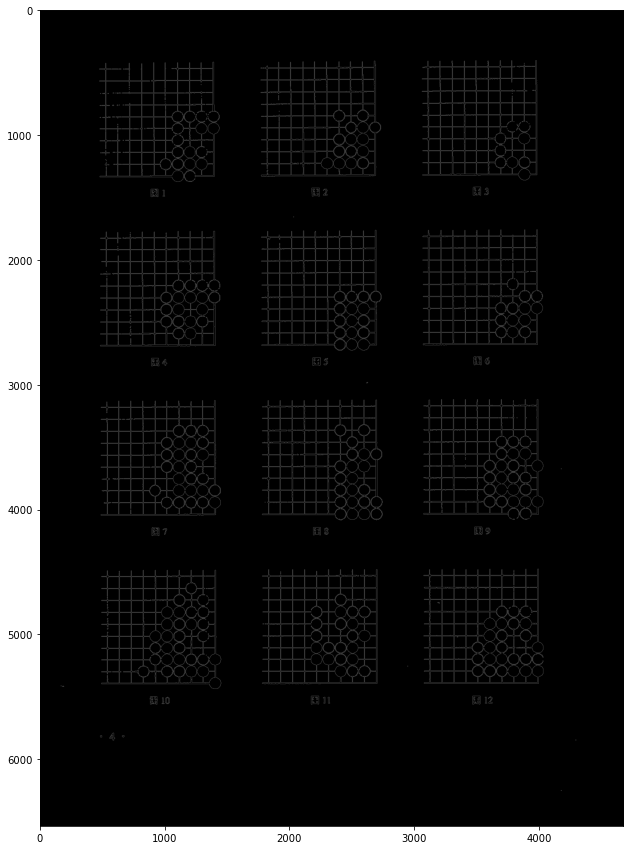

In [5]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
edges = get_edges(img_gray)
plt.imshow(to_RGB(edges))
plt.show() 

In [6]:
def all_lines(img_gray, hough_threshold):
    HOUGH_RHO = 1
    HOUGH_THETA = np.pi/180

    edges = get_edges(img_gray)
    size = min(img_gray.shape[0:2]) 
    lines = cv2.HoughLinesP(edges, rho=HOUGH_RHO, theta=HOUGH_THETA, threshold=hough_threshold,
                            minLineLength=size/2, maxLineGap=size) ### ?
    if lines is None:
        return None
    return np.reshape(lines, (lines.shape[0], lines.shape[2]))

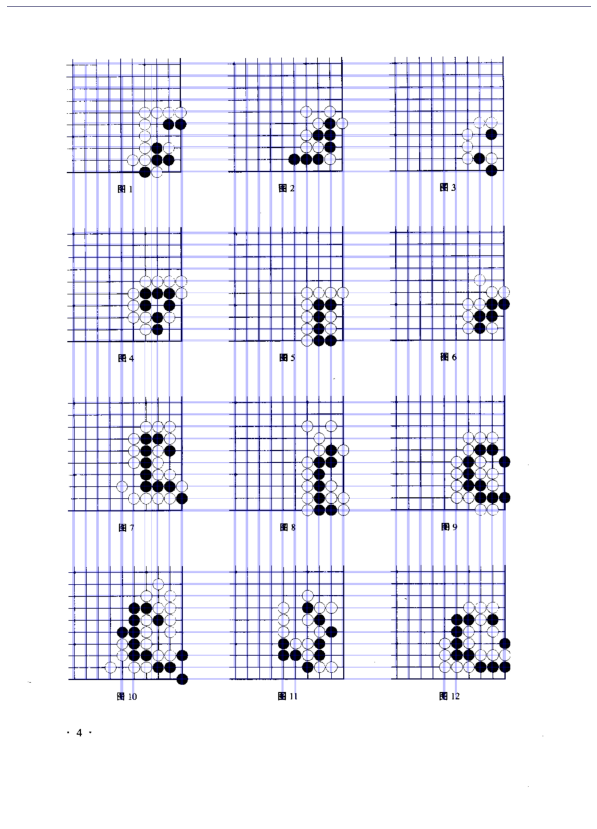

In [7]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
size = min(img_gray.shape[0:2])
lines = all_lines(img_gray, size//8)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [8]:
def get_verticals_horizontals(img_gray, hough_threshold):
    
        VERTICAL_TAN_MIN = 50
        HORIZONTAL_TAN_MAX = 0.02

        # Find all lines
        lines = all_lines(img_gray, hough_threshold)
        if (lines is None):
            return np.array([]), np.array([])
        # Divide the lines into verticals and horizontals
        v_lines = []
        h_lines = []
        for line in lines:
            x1, y1, x2, y2 = line
            if x1 == x2:
                line[1] = min(y1, y2)
                line[3] = max(y1, y2)
                v_lines.append(line)
            else:
                slope = (y2 - y1) / (x2 - x1)
                if abs(slope) > VERTICAL_TAN_MIN:
                    line[1] = min(y1, y2)
                    line[3] = max(y1, y2)
                    line[0] = line[2] = round(np.mean([x1, x2])) 
                    v_lines.append(line)
                elif abs(slope) < HORIZONTAL_TAN_MAX:
                    line[0] = min(x1, x2)
                    line[2] = max(x1, x2)
                    line[1] = line[3] = round(np.mean([y1, y2])) 
                    h_lines.append(line)
        v_lines = np.array(sorted(v_lines, key=lambda line: line[0]))
        h_lines = np.array(sorted(h_lines, key=lambda line: line[1]))
        return merge_lines(v_lines, True), merge_lines(h_lines, False)

In [9]:
def merge_lines(lines, is_vertical):
    MIN_DIST = 10
    
    if (lines.shape[0] == 0):
        return np.array([])
    ind =  0 if is_vertical else 1
    is_close = np.diff(lines, axis=0)[:, ind] <= MIN_DIST
    merged_lines = []
    i = 0
    while i < lines.shape[0]:
        close_lines = [lines[i]]
        while i + 1 < lines.shape[0] and is_close[i]:
            i += 1
            close_lines.append(lines[i])
        close_lines = np.array(close_lines)
        if is_vertical:
            x = round(np.mean(close_lines[:, ind]))
            merged_line = [x, np.amin(close_lines[:, 1]), x, np.amax(close_lines[:, 3])]
        else:
            y = round(np.mean(close_lines[:, ind]))
            merged_line = (np.amin(close_lines[:, 0]), y, np.amax(close_lines[:, 2]), y)
        merged_lines.append(merged_line)
        i += 1
    return np.array(merged_lines)

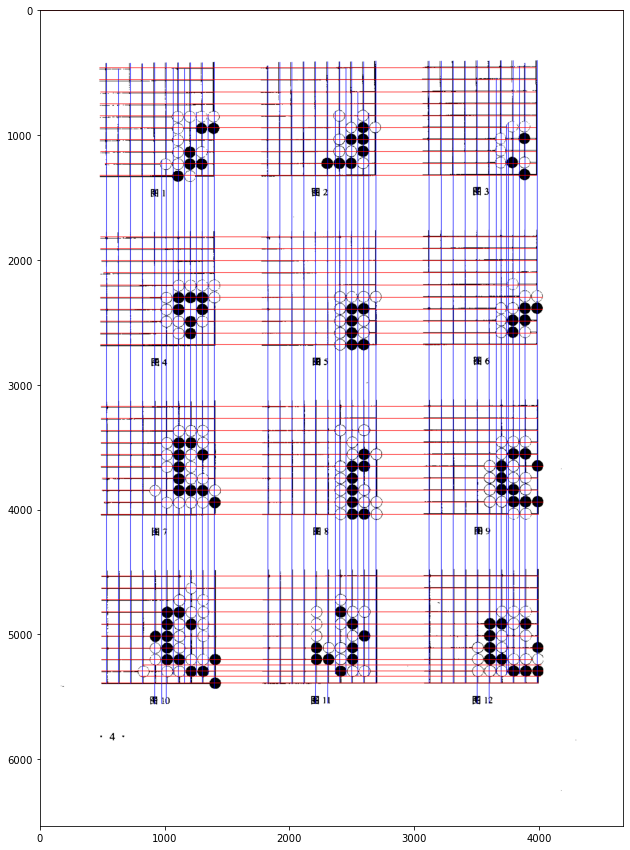

In [10]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
v_lines, h_lines =  get_verticals_horizontals(img_gray, 300)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2 ), (255, 0, 0), 3)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 3)
plt.imshow(to_RGB(img))
plt.show() 

In [11]:
def get_split_lines(lines, is_vertical):
    MIN_RATIO = 0.5
    
    if is_vertical:
        gaps = np.diff(lines[:, 0])
    else:
        gaps = np.diff(lines[:, 1])
    max_gap = np.amax(gaps)
    split_lines = []
    if is_vertical:
        split_line = lines[0] - [max_gap//2, 0, max_gap//2, 0]
    else:
        split_line = lines[0] - [0, max_gap//2, 0, max_gap//2]
    if not np.any(split_line < 0):
        split_lines.append(split_line)
    if np.mean(gaps) / max_gap < MIN_RATIO:
        for i in range(gaps.shape[0]):
            if gaps[i]/max_gap >= MIN_RATIO:
                split_line = np.mean(lines[i:i+2], axis=0).astype(int)
                split_lines.append(split_line)
    if is_vertical:
        split_line = lines[-1] + [max_gap//2, 0, max_gap//2, 0]
    else:
        split_line = lines[-1] + [0, max_gap//2, 0, max_gap//2]
    split_lines.append(split_line)
    split_lines = np.array(split_lines)
    print(split_lines)
    return np.array(split_lines)

[[ 318  425  318 5396]
 [1609  431 1609 5415]
 [2901  407 2901 5391]
 [4194  403 4194 5391]]
[[ 238  232 4324  232]
 [ 481 1569 3975 1569]
 [ 486 2925 3984 2925]
 [ 489 4285 3991 4285]
 [ 491 5635 3991 5635]]


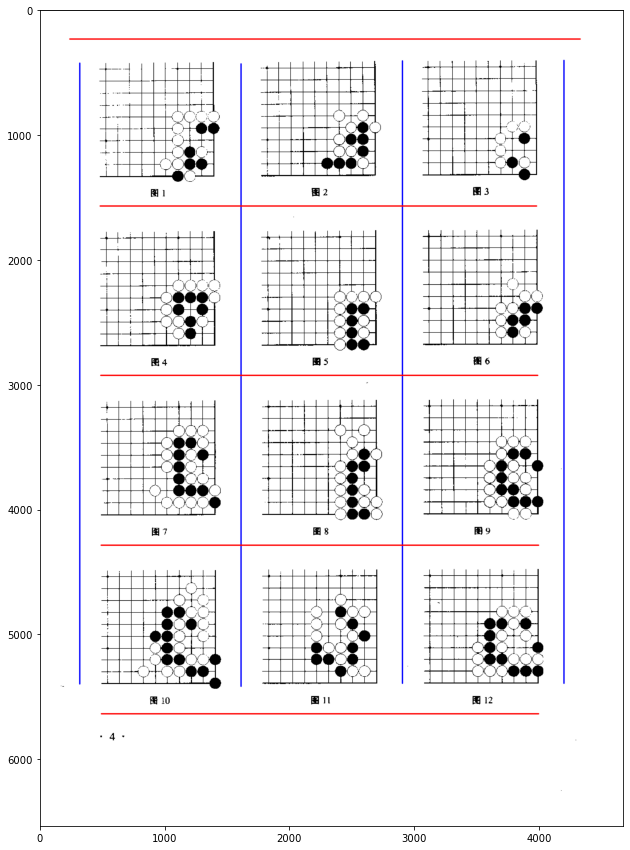

In [12]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
v_lines, h_lines =  get_verticals_horizontals(img_gray, 300)
img = cv2.imread(path, cv2.IMREAD_COLOR)
v_lines = get_split_lines(v_lines, True)
h_lines = get_split_lines(h_lines, False)

for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 10)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 10)
plt.imshow(to_RGB(img))
plt.show() 

In [13]:
def find_intersections(v_lines, h_lines):
    return np.array(np.meshgrid(v_lines[:, 0], h_lines[:, 1])).T

In [14]:
from enum import Enum, unique, auto

@unique
class RecognitionError(Enum):
    NO_IMG = auto()
    NO_LINES = auto()
    NO_BOARD = auto()



In [15]:
def split_into_boards(page_img):
    assert page_img is not None, RecognitionError.NO_IMG
    HOUGH_THRESHOLD = 300
    page_img_gray = cv2.cvtColor(page_img, cv2.COLOR_BGR2GRAY)
    v_lines, h_lines = get_verticals_horizontals(page_img_gray, HOUGH_THRESHOLD)
    v_lines = get_split_lines(v_lines, True)
    h_lines = get_split_lines(h_lines, False)
    assert len(v_lines) != 0 and len(h_lines) != 0, RecognitionError.NO_LINES
    intersections = find_intersections(v_lines, h_lines)
    board_images = []
    for j in range(intersections.shape[1] - 1):
        for i in range(intersections.shape[0] - 1):
            board_img = (page_img[intersections[i][j][1] :intersections[i + 1][j + 1][1],
                                  intersections[i][j][0] :intersections[i + 1][j + 1][0]])
            assert board_img is not None, RecognitionError.NO_BOARD
            board_images.append(board_img)
    return board_images

In [16]:
page_img = cv2.imread(path, cv2.IMREAD_COLOR)
boards = split_into_boards(page_img)

[[ 318  425  318 5396]
 [1609  431 1609 5415]
 [2901  407 2901 5391]
 [4194  403 4194 5391]]
[[ 238  232 4324  232]
 [ 481 1569 3975 1569]
 [ 486 2925 3984 2925]
 [ 489 4285 3991 4285]
 [ 491 5635 3991 5635]]


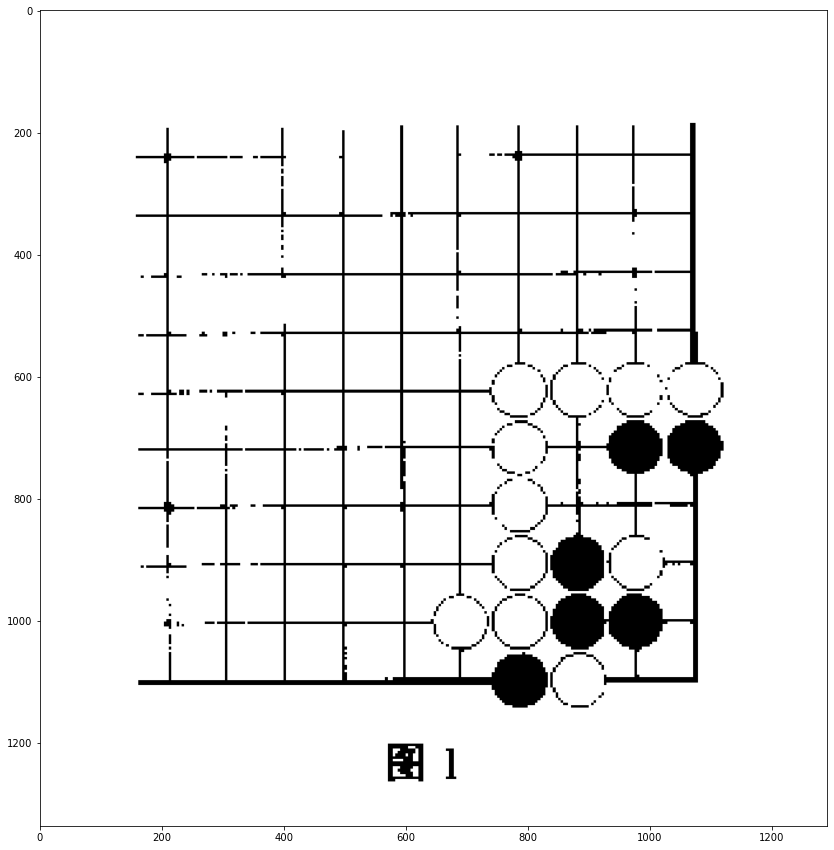

In [17]:
plt.imshow(boards[0])

In [18]:
def visualize(img, r):
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        intersections, white_stones, black_stones, radius, x_size, y_size, edges = r.recognize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        
        
        for intersection in np.reshape(intersections, (-1, 2)):
            cv2.circle(img, (intersection[0], intersection[1]), 5, (255,0,255), -1)
            
        up_edge, down_edge, left_edge, right_edge = edges
        if up_edge:
            for intersection in intersections[:, 0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if down_edge:
            for intersection in intersections[:, -1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if left_edge:
            for intersection in intersections[0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if right_edge:
            for intersection in intersections[-1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        
            
        for stone in white_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),3)
        for stone in black_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),3)
        plt.subplot(1, 2, 2)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        plt.show()

In [19]:
import sys  
sys.path.insert(0, './src')

In [20]:
import recognizer
r = recognizer.Recognizer()

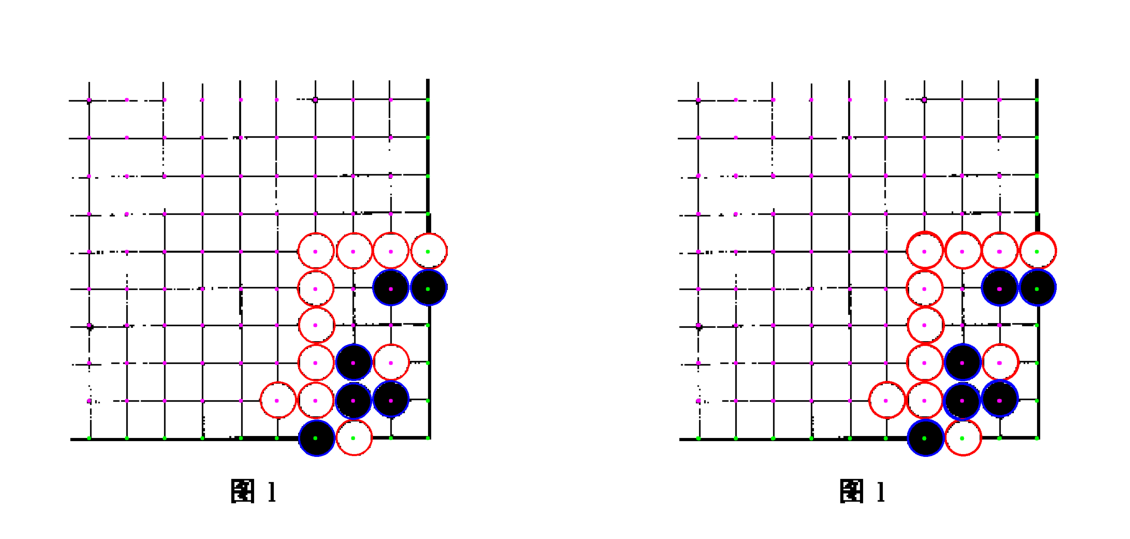

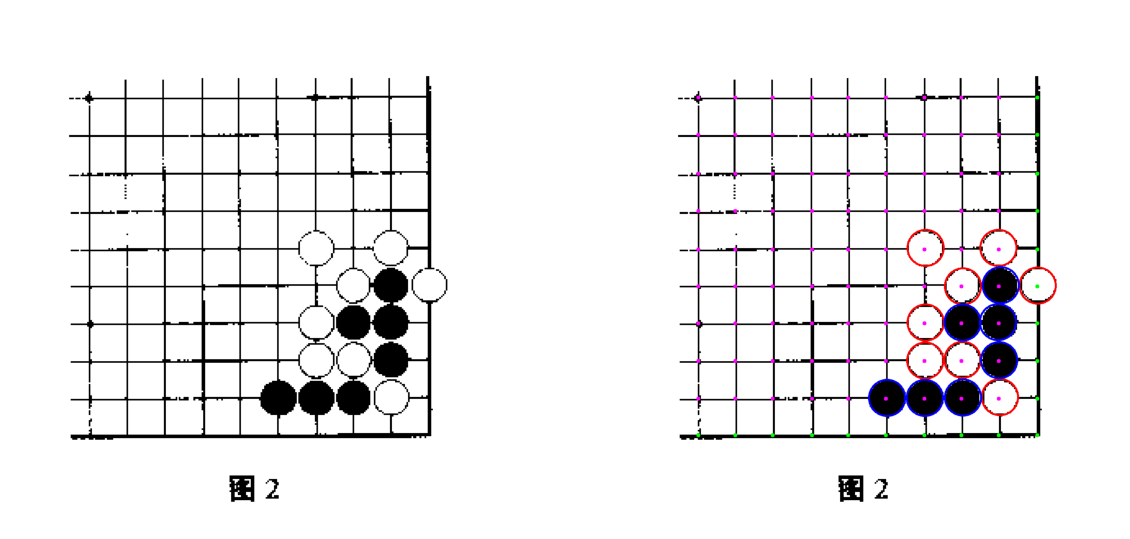

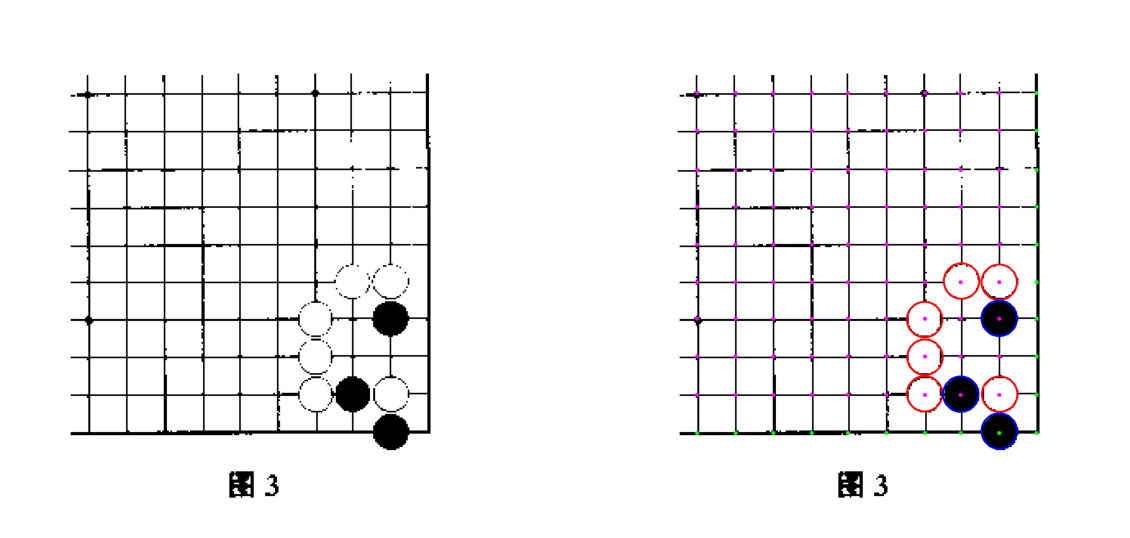

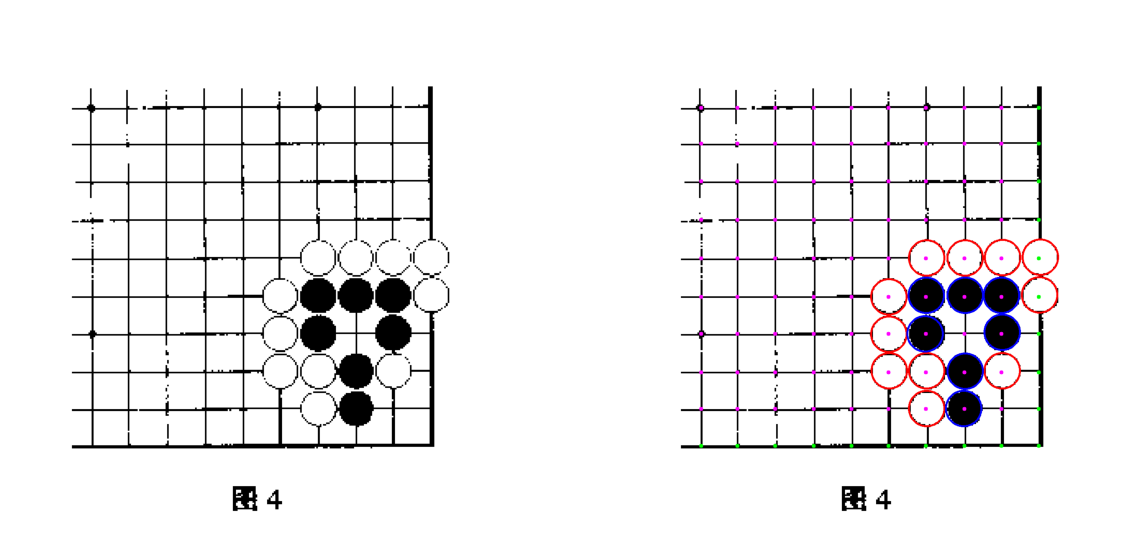

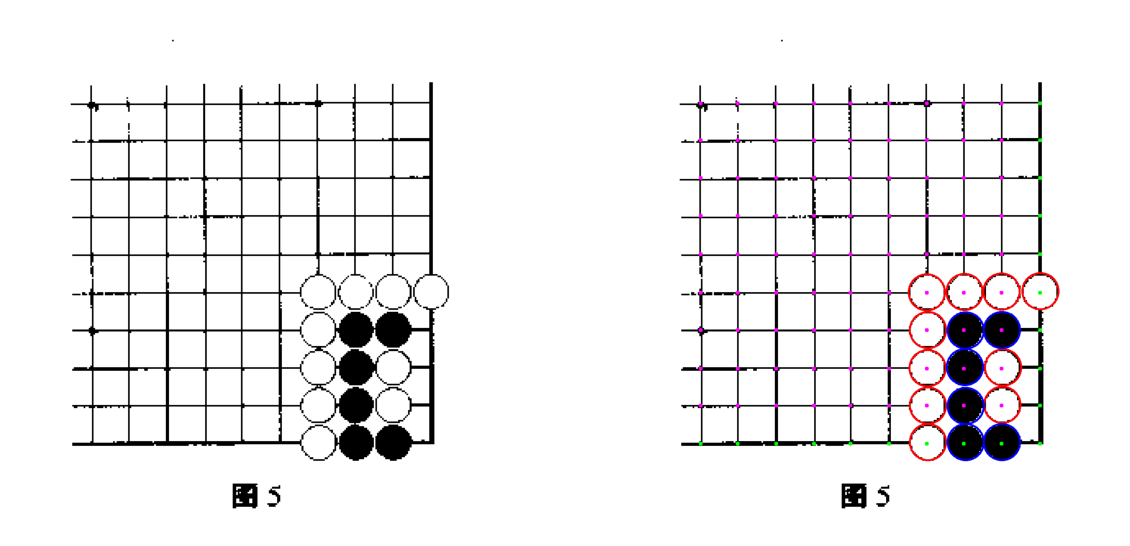

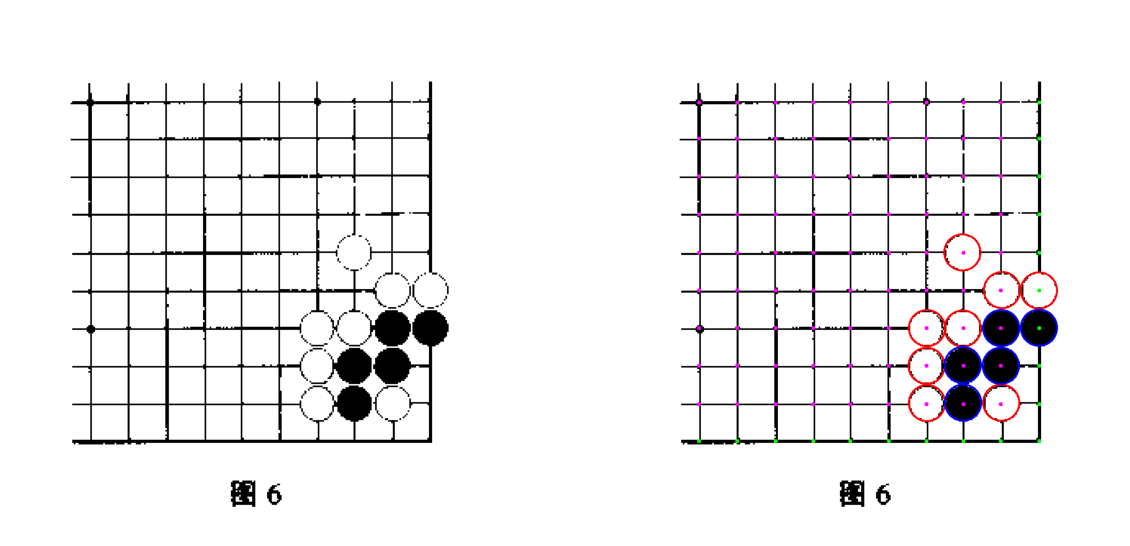

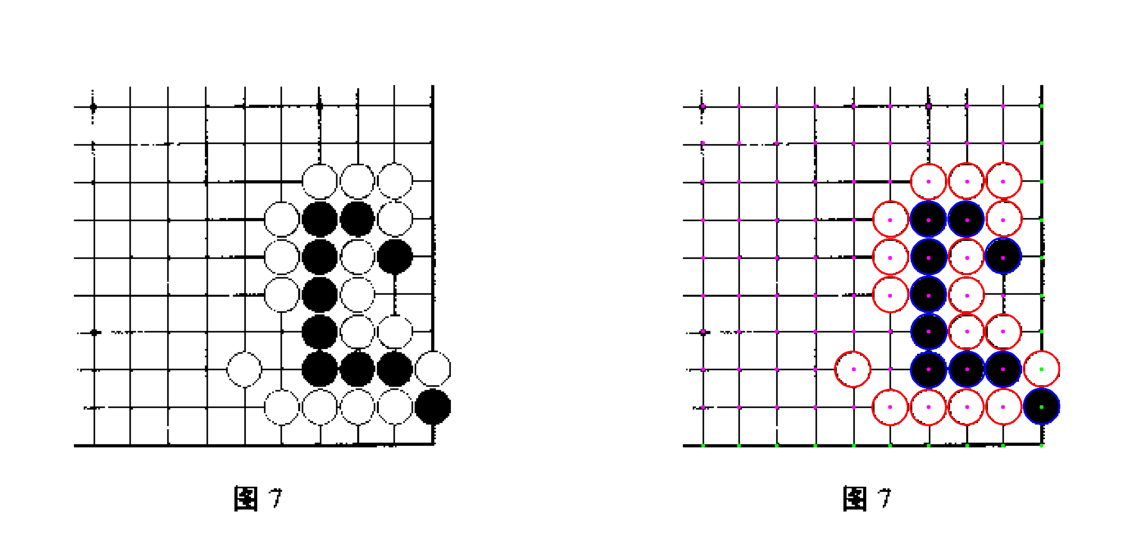

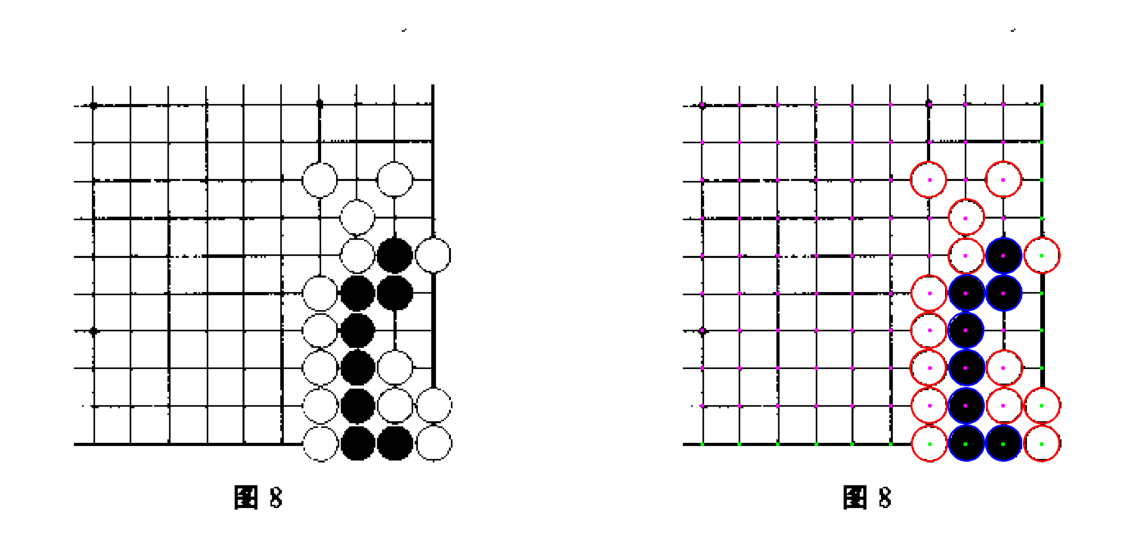

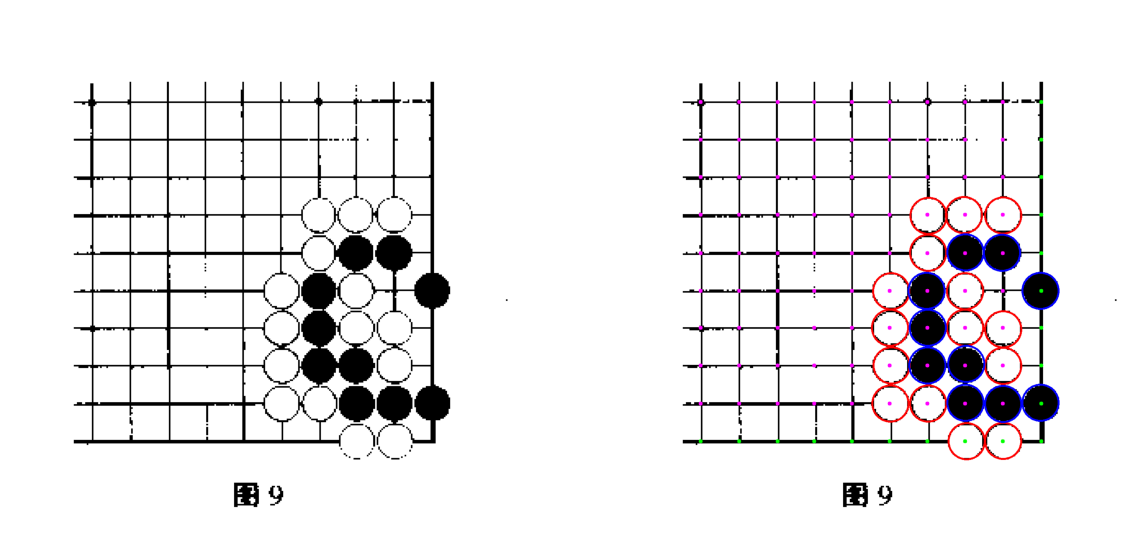

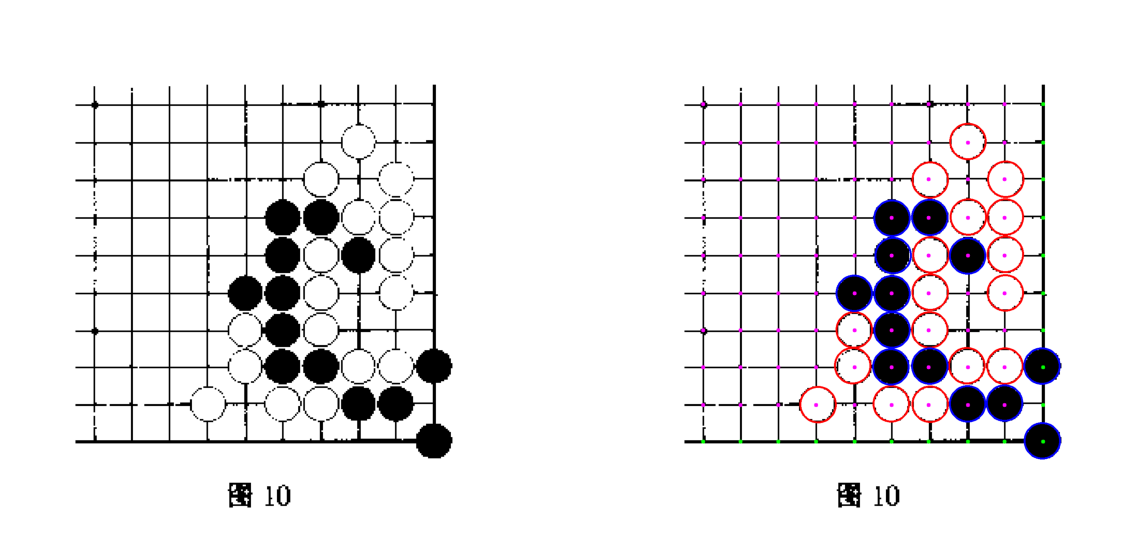

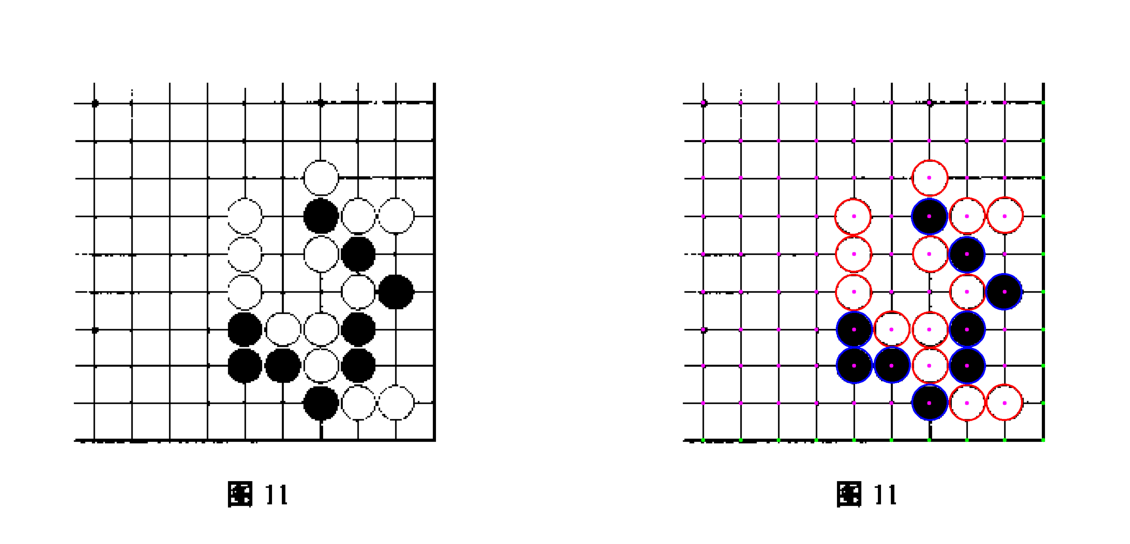

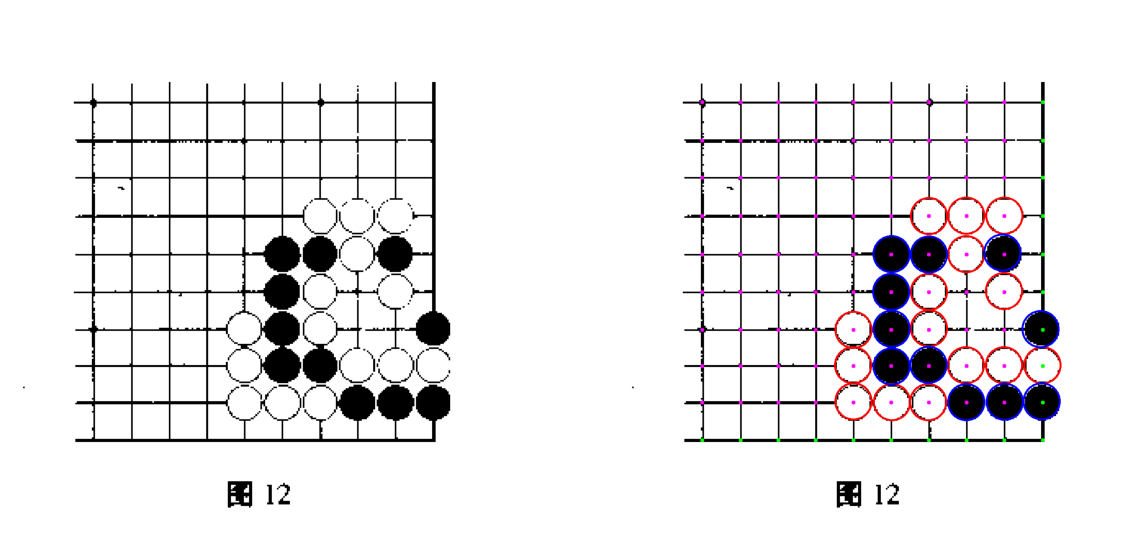

In [22]:
for i, board in enumerate(boards):
    visualize(board, r)
    #cv2.imwrite('t_{}.png'.format(i), board)

In [ ]:
os.listdir("data/tests/pages/chinese/default")

In [ ]:
import os

In [ ]:
pages = sorted([f for f in os.listdir("data/tests/pages/chinese/default") if not f.startswith('.')], key=lambda x: int(x[:-4]))

In [ ]:
pages

In [ ]:
for page in pages:
    path = 'data/tests/pages/chinese/default/' + page
    page_img = cv2.imread(path, cv2.IMREAD_COLOR)
    boards = r.split_into_boards(page_img)
    for i, board in enumerate(boards):
        try:
            img_path = 'data/tests/boards/chinese/default/{}_{}.png'.format(page[:-4], i)
            cv2.imwrite(img_path, board)
        except Exception as e:
            print(img_path)
            print(e)
            